In [25]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [48]:
dir_path = 'handwritten-leters'

In [49]:
data_info = ['letters.csv','letters2.csv','letters3.csv']

In [50]:
def import_data(data_info):
    data = pd.read_csv(dir_path + '/' + data_info)
    data['source'] = data_info[:-4]+'/'
    return data

In [51]:
import pandas as pd
letters = [import_data(file) for file in data_info]
data = pd.concat(letters, ignore_index=True)

In [52]:
data.head()

,letter,label,file,background,source
0,а,1,01_01.png,0,letters/
1,а,1,01_02.png,0,letters/
2,а,1,01_03.png,0,letters/
3,а,1,01_04.png,0,letters/
4,а,1,01_05.png,0,letters/


In [53]:
from sklearn.utils import shuffle

data = shuffle(data, random_state = 42)
data.head()

,letter,label,file,background,source
6491,щ,27,27_212.png,2,letters2/
2012,в,3,03_53.png,2,letters2/
13295,ы,29,29_336.png,3,letters3/
11270,с,19,19_311.png,3,letters3/
12837,щ,27,27_278.png,3,letters3/


# Target preprocessing

In [54]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder()

arr =  one_hot_enc.fit_transform(data[['letter']])
data['enc_letter'] = pd.DataFrame(arr)
arr1 =  one_hot_enc.fit_transform(data[['background']])
data['enc_background'] = pd.DataFrame(arr1)
data.head()

,letter,label,file,background,source,enc_letter,enc_background
6491,щ,27,27_212.png,2,letters2/,"(0, 21)\t1.0","(0, 2)\t1.0"
2012,в,3,03_53.png,2,letters2/,"(0, 2)\t1.0","(0, 3)\t1.0"
13295,ы,29,29_336.png,3,letters3/,"(0, 32)\t1.0","(0, 3)\t1.0"
11270,с,19,19_311.png,3,letters3/,"(0, 19)\t1.0","(0, 3)\t1.0"
12837,щ,27,27_278.png,3,letters3/,"(0, 32)\t1.0","(0, 1)\t1.0"


In [96]:
# Get all labels in one string
letters = '' 
for letter in data.letter.unique():
    letters += letter
    print(letters)
    
# Which letter is written on each image
labels = data.label
# print(labels)
def ohe_letter(label):
    result = np.zeros(len(letters))
    
    index = letters.index(label)
    result[index] = 1
    return result

def ohe_background(label):
    result = np.zeros(len(data.background.unique()))
    result[label] = 1
    return result

In [97]:
data['enc_letter'] = data['letter'].apply(ohe_letter)
data['enc_background'] = data['background'].apply(ohe_background)
data.head()


,letter,label,file,background,source,enc_letter,enc_background
6491,щ,27,27_212.png,2,letters2/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,03_53.png,2,letters2/,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,29_336.png,3,letters3/,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,19_311.png,3,letters3/,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,27_278.png,3,letters3/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"


# Image preprocesssing

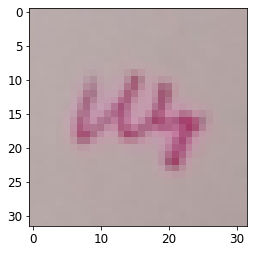

In [57]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image

img_width, img_height = 32,32
input_shape = (img_width,img_height,3)

# image_file_name = dir_path + '/'+'letters2/23_89.png'
image_file_name = dir_path +'/'+ 'letters2/27_212.png'
img = image.load_img(image_file_name,target_size=(img_width, img_height))
plt.imshow(img)

In [98]:
# Store all png images into one numpy array
images = []

# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# Want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    #converting image
    numpy_image = cv2.imread(os.path.join(dir_path +'/'+ row['source'],img_name))
#     print(numpy_image)
    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['enc_letter'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['enc_background'])
        
# Normalize array of images
images = np.array(images)/255

In [99]:
len(images), len(encoded_labels)

(14178, 14178)

In [100]:

X = np.array(images.copy())
y = np.array(encoded_labels.copy())


In [101]:
from sklearn.model_selection import train_test_split
# from keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,
                                                 random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

# y_binary = keras.utils.to_categorical(y_train)

(11342, 32, 32, 3)
(2836, 32, 32, 3)
(11342, 33)
(2836, 33)


# Data Augmentation

In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_aug = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.10,
                              height_shift_range=0.10,
                              rescale=1/255,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

data_aug.fit(X_train)

# Configuring of CNN

In [103]:
input_shape = (img_width,img_height,3)

letters = ''
for letter in data.letter.unique():
    letters += letter
num_classes = len(letters)
print(num_classes)
#group of training samples
batch_size=64

epochs = 20

33


In [104]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32,kernel_size=(3,3),
                activation='relu',
                input_shape=input_shape),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(0.20),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(num_classes,activation='softmax')
])

In [105]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [106]:
history = model.fit(X_train, y_train,
          batch_size = batch_size,
          epochs=epochs,
          verbose = 1,
          validation_data = (X_val,y_val))

Train on 11342 samples, validate on 2836 samples
Epoch 1/20
11342/11342 [==============================] - 152s 13ms/sample - loss: 3.4038 - accuracy: 0.0585 - val_loss: 2.9391 - val_accuracy: 0.1961
Epoch 2/20
11342/11342 [==============================] - 744s 66ms/sample - loss: 2.5967 - accuracy: 0.2664 - val_loss: 2.1609 - val_accuracy: 0.4055
Epoch 3/20
11342/11342 [==============================] - 197s 17ms/sample - loss: 2.1102 - accuracy: 0.3978 - val_loss: 1.8179 - val_accuracy: 0.4926
Epoch 4/20
11342/11342 [==============================] - 1628s 144ms/sample - loss: 1.7371 - accuracy: 0.4989 - val_loss: 1.5336 - val_accuracy: 0.5606
Epoch 5/20
11342/11342 [==============================] - 149s 13ms/sample - loss: 1.4360 - accuracy: 0.5821 - val_loss: 1.2295 - val_accuracy: 0.6548
Epoch 6/20
11342/11342 [==============================] - 162s 14ms/sample - loss: 1.2346 - accuracy: 0.6362 - val_loss: 1.1205 - val_accuracy: 0.6756
Epoch 7/20
11342/11342 [===================

[0.0584553, 0.2664433, 0.39781344, 0.49885383, 0.5820843, 0.6362194, 0.6743079, 0.6945865, 0.7207723, 0.73937577, 0.75991887, 0.7786986, 0.79765475, 0.8070887, 0.81952035, 0.83010054, 0.8430612, 0.8533768, 0.8591959, 0.8652795]


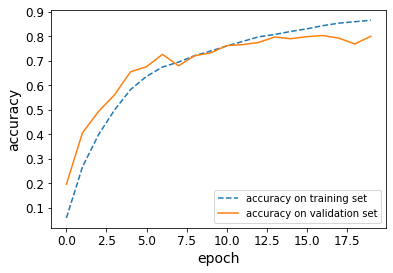

In [107]:
print(history.history['accuracy'])

plt.plot(history.history['accuracy'],'--',label='accuracy on training set')
plt.plot(history.history['val_accuracy'],label='accuracy on validation set')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

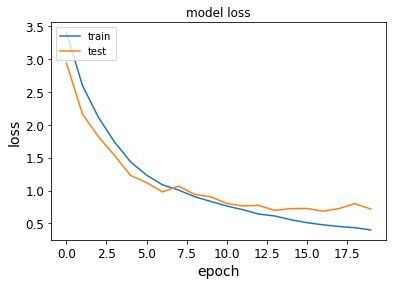

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper left')
plt.show()